<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/classifica%C3%A7%C3%A3o/DecisionTreeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas necessárias

In [34]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# Importando dados 

In [16]:
dataset = pd.read_csv("dados_ies_novas_categorias_utf8.csv", index_col=0, encoding="latin-1")

# Selecionando features

In [24]:
X = dataset.drop(columns=[ 
                          "UF",
                          "REGIAO",
                          "TIPO_CATEGORIA_ADM",
                          "CODIGO_IES"
                          ])
y = dataset["TIPO_CATEGORIA_ADM"].values

feature_cols = [
                "DEFICIENCIA_FISICA",
                "DEFICIENCIA_VISUAL",
                "DEFICIENCIA_COGNITIVA",
                "DEFICIENCIA_AUDITIVA",
                "DEFICIENCIA_MULTIPLA",
                "RECURSOS_DEF_FISICA",
                "RECURSOS_DEF_VISUAL",
                "RECURSOS_DEF_COGNITIVA",
                "RECURSOS_DEF_AUDITIVA",
                "RECURSOS_DEF_MULTIPLA",
                "NUM_CURSOS"
                ]

print(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1) #60% para treino e 40% para teste

      NUM_CURSOS  ...  RECURSOS_DEF_MULTIPLA
0            114  ...               0.201754
1            149  ...               1.852349
2            116  ...               0.534483
3            107  ...               0.000000
4            100  ...               2.520000
...          ...  ...                    ...
2601           2  ...               0.000000
2602           2  ...               0.000000
2603           1  ...               0.000000
2605           1  ...               1.000000
2607           1  ...               2.000000

[235 rows x 11 columns]


# Criando a árvore

In [25]:
da = DecisionTreeClassifier()

da = da.fit(X_train, y_train)

y_pred = da.predict(X_test)

# Avaliação do algoritmo

In [26]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.723404255319149


# Visualizando a árvore

In [27]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

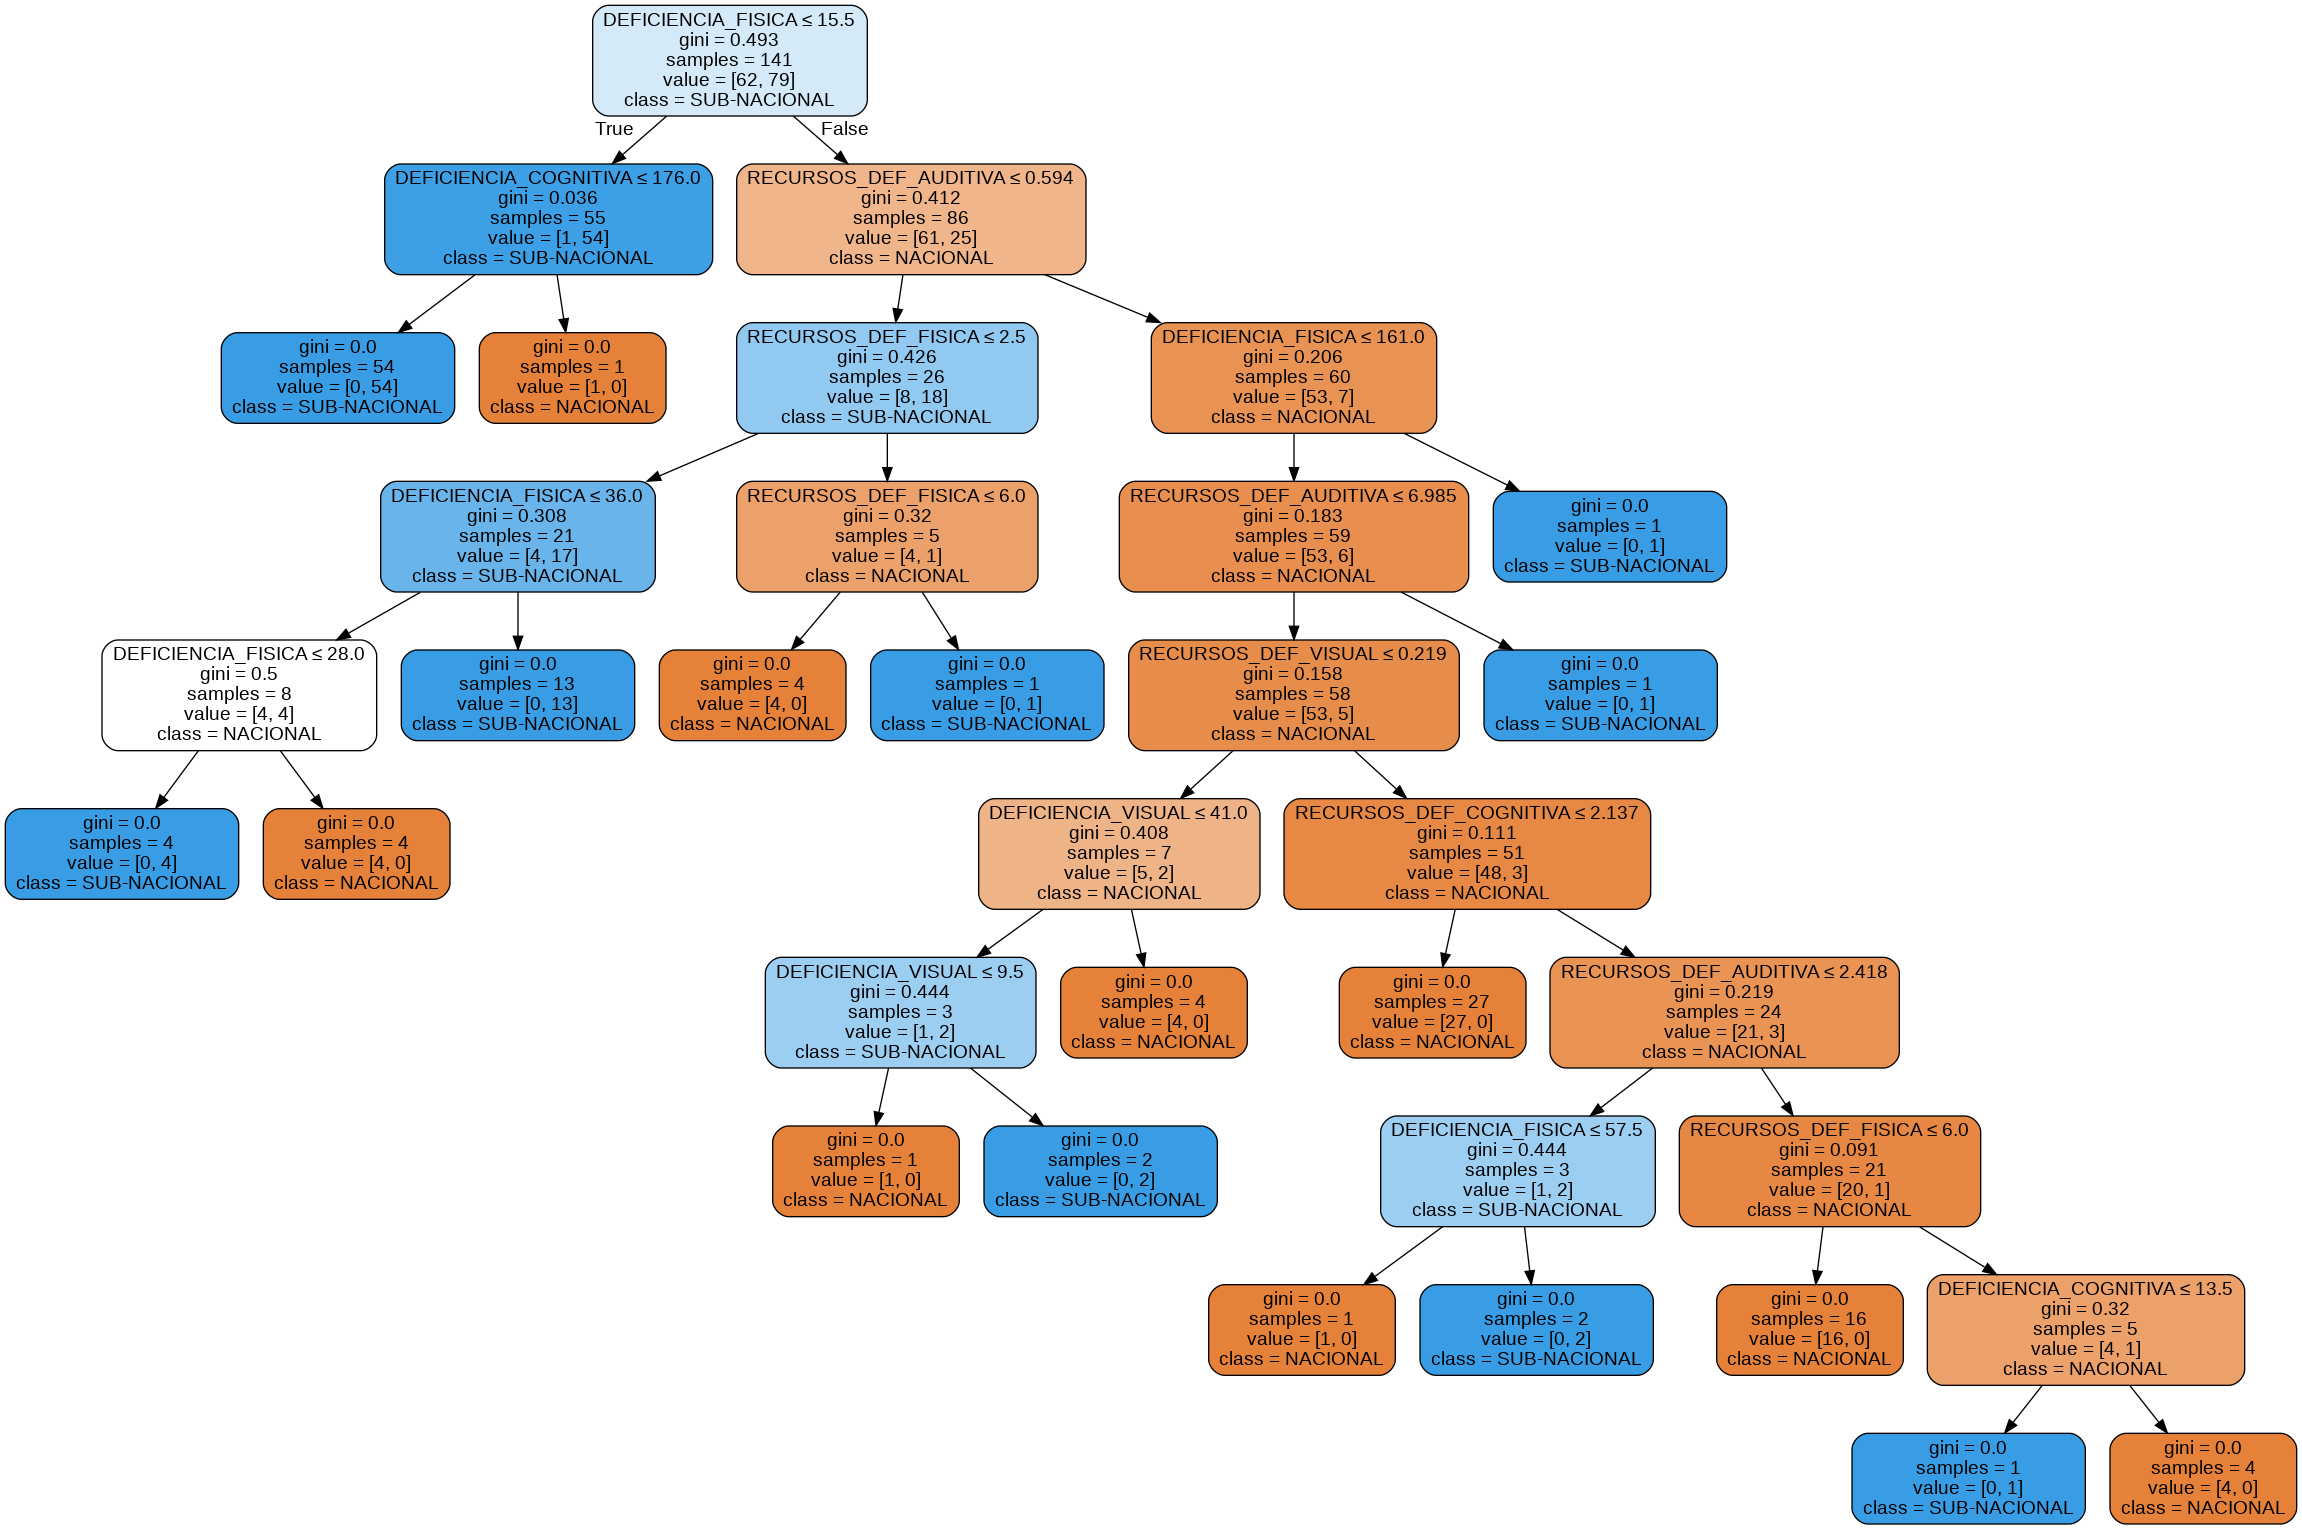

In [29]:
ddata = StringIO()
export_graphviz(
                da, 
                out_file=ddata, 
                filled=True, 
                rounded=True, 
                special_characters=True, 
                feature_names=feature_cols, 
                class_names=["NACIONAL", "SUB-NACIONAL"]
                )
graph = pydotplus.graph_from_dot_data(ddata.getvalue())
graph.write_png("categoria_administrativa.png")
Image(graph.create_png())

# Usando o feature importance

In [39]:
features_dict= {}
for col, val in sorted(zip(X_train.columns, da.feature_importances_), key=lambda x:x[1], reverse=True):
  features_dict[col] = val

features_df = pd.DataFrame({'Feature':features_dict.keys(),'Importance': features_dict.values()})

features_df

,Feature,Importance
0,NUM_CURSOS,0.596515
1,RECURSOS_DEF_AUDITIVA,0.225622
2,DEFICIENCIA_MULTIPLA,0.070608
3,DEFICIENCIA_AUDITIVA,0.051294
4,DEFICIENCIA_FISICA,0.041125
5,RECURSOS_DEF_FISICA,0.009122
6,RECURSOS_DEF_VISUAL,0.005715
7,DEFICIENCIA_VISUAL,0.000000
8,DEFICIENCIA_COGNITIVA,0.000000
9,RECURSOS_DEF_COGNITIVA,0.000000
